


# Objective

The objective of the notebook is to build a face detection system that can detect multiple faces.

![alt text](https://drive.google.com/uc?export=view&id=1IyzOz2M9CLM9HYod0KZNVOxdXLk4AwxR)


# Steps to solve the Face Detection problem

1. Install Dependencies
2. Loading and pre-processing the data
3. Creating annotations as per Detectron2
4. Register the dataset
5. Fine Tuning the model
6. Evaluating model performance

##1. Install Dependencies


In [ ]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 31.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=38342a5c5d484189ed1b0e5a28f7d4473ff31960032348acbda919478219aaba
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-d9fc8iiw
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-d9fc8iiw
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 79 kB

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


##2. Loading and pre-processing the data

In [ ]:
# mounting drive
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
# extracting files
!unzip '/content/drive/MyDrive/Wider_faces/Copy of WIDER_train.zip'
!unzip '/content/drive/MyDrive/Wider_faces/Copy of WIDER_val.zip'
!unzip '/content/drive/MyDrive/Wider_faces/Copy of wider_face_split.zip'

Streaming output truncated to the last 5000 lines.
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_498.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_501.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_504.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_507.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_509.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_518.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_529.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_533.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_spor

In [ ]:
# reading files
import pandas as pd

# specify path of the data
path_train = '/content/wider_face_split/wider_face_train_bbx_gt.txt'
path_val = '/content/wider_face_split/wider_face_val_bbx_gt.txt'

# reading data
train = pd.read_csv(path_train,header=None)
val = pd.read_csv(path_val,header=None)

In [ ]:
# first 10 rows
train.head(10)

,0
0,0--Parade/0_Parade_marchingband_1_849.jpg
1,1
2,449 330 122 149 0 0 0 0 0 0
3,0--Parade/0_Parade_Parade_0_904.jpg
4,1
5,361 98 263 339 0 0 0 0 0 0
6,0--Parade/0_Parade_marchingband_1_799.jpg
7,21
8,78 221 7 8 2 0 0 0 0 0
9,78 238 14 17 2 0 0 0 0 0


![alt text](https://drive.google.com/uc?export=view&id=1WN_V0rOz_vLSV6JK-oWHamUxjXUZ-0Wp)

In [ ]:
# pre-processing data
# this function accepts the dataframe and returns modified dataframe
def reformat(df):
  
  # fetch values of first column
  values = df[0].values

  # creating empty lists
  names=[]
  num_faces=[]
  bbox=[]

  # fetch values into corresponding lists
  for i in range(len(values)):
      
      # if an image
      if ".jpg" in values[i]:
        
        # no. of faces
        num=int(values[i+1])
        
        # append image name to list
        names.append(values[i])
        
        # append no. of faces to list
        num_faces.append(num)
        
        # create bbox list
        box=[]
        for j in range(i+2,i+2+num):
          box.append(values[j])
        
        # append bbox list to list
        bbox.append(box)
  
  return pd.DataFrame({'name':names,'num_faces':num_faces,'bbox':bbox})

In [ ]:
# pre-processing the data 
train = reformat(train)
val = reformat(val)

In [ ]:
# first 5 rows of the pre-processed data
train.head()

,name,num_faces,bbox
0,0--Parade/0_Parade_marchingband_1_849.jpg,1,[449 330 122 149 0 0 0 0 0 0 ]
1,0--Parade/0_Parade_Parade_0_904.jpg,1,[361 98 263 339 0 0 0 0 0 0 ]
2,0--Parade/0_Parade_marchingband_1_799.jpg,21,"[78 221 7 8 2 0 0 0 0 0 , 78 238 14 17 2 0 0 0..."
3,0--Parade/0_Parade_marchingband_1_117.jpg,9,"[69 359 50 36 1 0 0 0 0 1 , 227 382 56 43 1 0 ..."
4,0--Parade/0_Parade_marchingband_1_778.jpg,35,"[27 226 33 36 1 0 0 0 2 0 , 63 95 16 19 2 0 0 ..."


In [ ]:
# shape of the training data
train.shape

(12880, 3)

In [ ]:
# adding full path
train['name'] = train['name'].apply(lambda x: 'WIDER_train/images/'+x )
val['name']   = val['name'].apply(lambda x: 'WIDER_val/images/'+x )

In [ ]:
# converting bbox to floating point
import numpy as np
train['bbox'] = train['bbox'].apply(lambda row:[ np.float_(annos.split()) for annos in row] )
val['bbox']   = val['bbox'].apply(lambda row:[ np.float_(annos.split()) for annos in row] )

In [ ]:
# extracting class names
train['class']= train['name'].apply(lambda x:x.split("/")[2].split("--")[1])
val['class']  = val['name'].apply(lambda x:x.split("/")[2].split("--")[1])

In [ ]:
# reading class names
easy_df = pd.read_csv('/content/drive/MyDrive/Wider_faces/Copy of easy.txt',header=None)
easy_labels = easy_df[0].values

In [ ]:
# creating empty dataframes
train_df, val_df= pd.DataFrame(), pd.DataFrame()

# fetching rows of easy classes only
for i in easy_labels:
  train_df = pd.concat( [train_df, train[train['class']==i]] )
  val_df   = pd.concat( [val_df, val[val['class']==i]] )

In [ ]:
# shape of dataframe
train_df.shape, val_df.shape

((2307, 4), (577, 4))

In [ ]:
# first 5 rows
train_df.head()

,name,num_faces,bbox,class
7983,WIDER_train/images/40--Gymnastics/40_Gymnastic...,1,"[[480.0, 212.0, 102.0, 120.0, 0.0, 0.0, 0.0, 0...",Gymnastics
7984,WIDER_train/images/40--Gymnastics/40_Gymnastic...,15,"[[971.0, 353.0, 8.0, 13.0, 2.0, 0.0, 0.0, 0.0,...",Gymnastics
7985,WIDER_train/images/40--Gymnastics/40_Gymnastic...,1,"[[393.0, 974.0, 112.0, 73.0, 1.0, 0.0, 0.0, 0....",Gymnastics
7986,WIDER_train/images/40--Gymnastics/40_Gymnastic...,9,"[[222.0, 190.0, 43.0, 52.0, 0.0, 0.0, 0.0, 0.0...",Gymnastics
7987,WIDER_train/images/40--Gymnastics/40_Gymnastic...,1,"[[336.0, 68.0, 236.0, 412.0, 0.0, 0.0, 0.0, 0....",Gymnastics


## 3. Creating annotations as per Detectron2

We will see how to convert the annotations of wider dataset to the annotations of Detectron2

In [ ]:
# custom annotation format
idx=0
values = train_df.values[idx]
print(values)

['WIDER_train/images/40--Gymnastics/40_Gymnastics_Gymnastics_40_785.jpg' 1
 list([array([480., 212., 102., 120.,   0.,   0.,   0.,   0.,   0.,   0.])])
 'Gymnastics']


![alt text](https://drive.google.com/uc?export=view&id=1AxlMNsub4dt7ARohSlF6mWX7fZmSVmqF)

In [ ]:
# for dealing with images
import cv2

# create annotation dict 
record = {}

# image name        
filename = values[0]

# height and width of an image
height, width = cv2.imread(filename).shape[:2]

# creating fields    
record["file_name"] = filename
record["image_id"] = 0
record["height"] = height
record["width"] = width

In [ ]:
# different ways to represent bounding box
from detectron2.structures import BoxMode

# create bbox list
objs = []

# for every face in an image
for i in range(len(values[2])):
  
  # fetch bbox coordinates
  annos = values[2][i]

  # unpack values
  x1, y1, w, h = annos[0], annos[1], annos[2], annos[3]
  
  # compute bottom right corner
  x2, y2 = x1 + w, y1 + h
  
  # create bbox dict
  obj = {       "bbox": [x1, y1, x2, y2],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": 0,
                "iscrowd": 0
        }

  # append bbox dict to a bbox list
  objs.append(obj)

In [ ]:
# assign bbox list to annotation dict
record["annotations"] = objs

In [ ]:
# standard annotation format
record

{'annotations': [{'bbox': [480.0, 212.0, 582.0, 332.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0}],
 'file_name': 'WIDER_train/images/40--Gymnastics/40_Gymnastics_Gymnastics_40_785.jpg',
 'height': 683,
 'image_id': 0,
 'width': 1024}

In [ ]:
def create_annotation(df):  
  
  # creating empty list to store annotations
  dataset_dicts = []

  # for each image 
  for idx, v in enumerate(df.values):
    
    # create annotation dict 
    record = {}

    # image name        
    filename = v[0]

    # height and width of an image
    height, width = cv2.imread(filename).shape[:2]

    # assign values to fields    
    record["file_name"] = filename
    record["image_id"] = idx
    record["height"] = height
    record["width"] = width

    # create bbox list
    objs = []

    # for each face in an image
    for i in range(len(v[2])):
      
      # bounding box coordinates
      annos = v[2][i]
      
      # unpack values
      x1, y1, w, h = annos[0], annos[1], annos[2], annos[3]
      
      # find bottom right corner
      x2, y2 = x1 + w, y1 + h
      
      # create bbox dict
      obj = {   "bbox": [x1, y1, x2, y2],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": 0,
                "iscrowd": 0
            }
      
      # append bbox dict to bbox list
      objs.append(obj)
    
    # assign bbox list to annotation dict
    record["annotations"] = objs

    # append annotation dict to list
    dataset_dicts.append(record)
  
  return dataset_dicts

In [ ]:
# create standard annotations for training and validation datasets
train_annotation = create_annotation(train_df)
val_annotation   = create_annotation(val_df)

In [ ]:
# standard annotation of an image
train_annotation[1]

{'annotations': [{'bbox': [971.0, 353.0, 979.0, 366.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0},
  {'bbox': [934.0, 363.0, 943.0, 376.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0},
  {'bbox': [500.0, 201.0, 546.0, 258.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0},
  {'bbox': [248.0, 517.0, 298.0, 573.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0},
  {'bbox': [344.0, 504.0, 388.0, 560.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0},
  {'bbox': [660.0, 489.0, 704.0, 545.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0},
  {'bbox': [725.0, 527.0, 773.0, 585.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0},
  {'bbox': [583.0, 662.0, 634.0, 721.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0},
  {'bbox': [487.0, 670.0, 540.0, 

##4. Register the dataset

To let detectron2 know how to obtain a dataset, we will implement a function that returns the items in your dataset and then tell detectron2 about this function. For this, we will follow these steps:

1. Register your dataset (i.e., tell detectron2 how to obtain your dataset).

2. Optionally, register metadata for your dataset.

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# register dataset
DatasetCatalog.register("face_train", lambda d="train": create_annotation(train_df))

# register metadata
MetadataCatalog.get("face_train").set(thing_classes=["face"])

Metadata(name='face_train', thing_classes=['face'])

In [ ]:
# for drawing bounding boxes on images
from detectron2.utils.visualizer import Visualizer

# for displaying an image
from google.colab.patches import cv2_imshow

# for randomly selecting images
import random

# get the name of the classes
face_metadata = MetadataCatalog.get("face_train")

print(face_metadata)

Metadata(name='face_train', thing_classes=['face'])


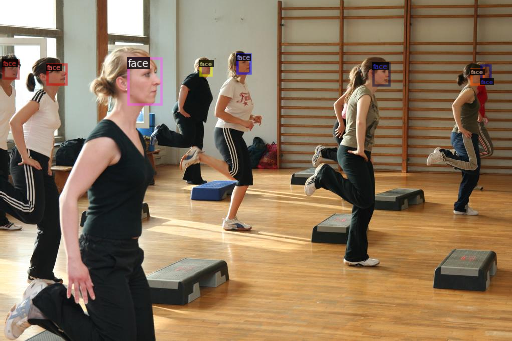

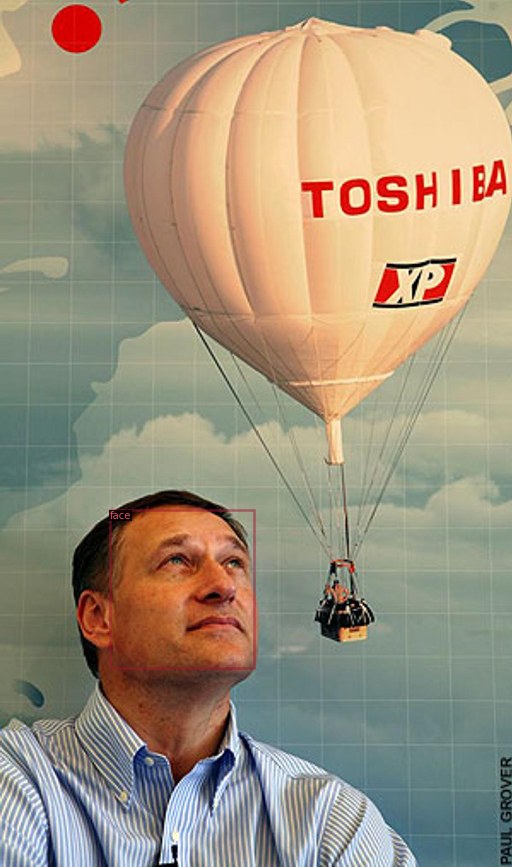

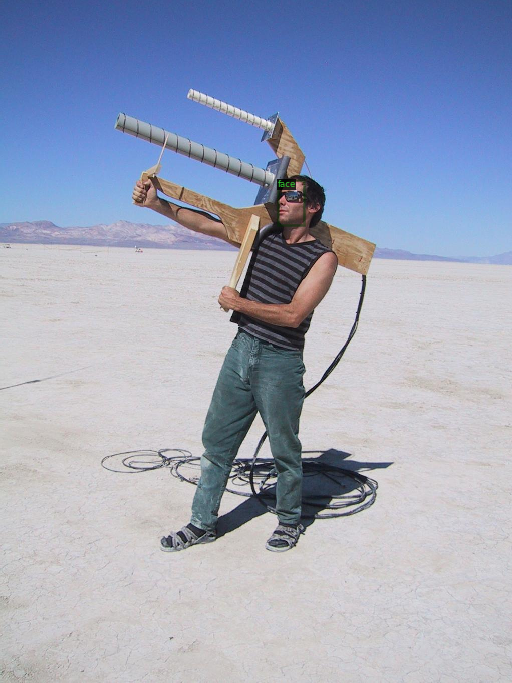

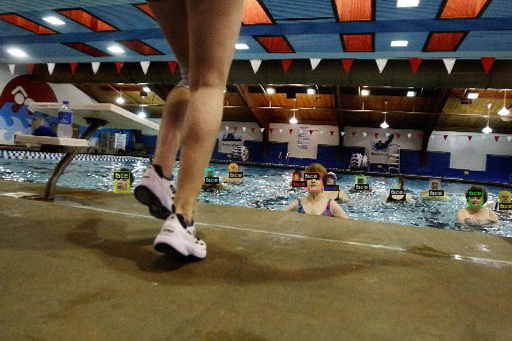

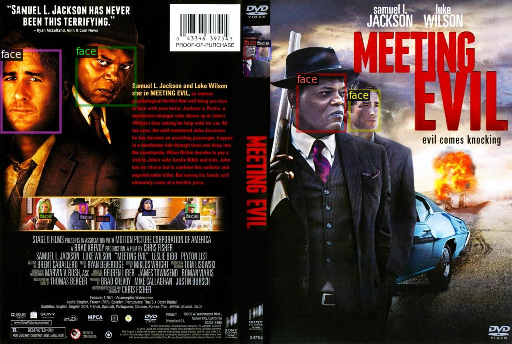

In [ ]:
# randomly select images
for d in random.sample(train_annotation, 5):
  
  # read an image
  img = cv2.imread(d["file_name"])

  # create visualizer
  visualizer = Visualizer(img[:, :, ::-1], metadata=face_metadata, scale=0.5)
  
  # draw bounding box on image
  vis = visualizer.draw_dataset_dict(d)
  
  # display an image
  cv2_imshow(vis.get_image()[:, :, ::-1])

## 5. Fine Tuning the model

In [ ]:
# to obtain pretrained models
from detectron2 import model_zoo

# to train the model
from detectron2.engine import DefaultTrainer

# set up the config
from detectron2.config import get_cfg

# interact with os
import os

# define configure instance
cfg = get_cfg()

# Get a model specified by relative path under Detectron2’s official configs/ directory.
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))

# load pretrained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")

Loading config /usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [ ]:
# List of the dataset names for training. Must be registered in DatasetCatalog
cfg.DATASETS.TRAIN = ("face_train",)

cfg.DATASETS.TEST = ()

In [ ]:
# no. of images per batch
cfg.SOLVER.IMS_PER_BATCH = 2

#set base learning rate
cfg.SOLVER.BASE_LR = 0.001  

#no. of iterations
cfg.SOLVER.MAX_ITER = 1000

# only has one class (face)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

In [ ]:
# create directory to save weights
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# create a trainer with given config
trainer = DefaultTrainer(cfg) 

# If resume==True, and last checkpoint exists, resume from it, load all checkpointables (eg. optimizer and scheduler) and update iteration counter.
# Otherwise, load the model specified by the config (skip all checkpointables) and start from the first iteration.
trainer.resume_or_load(resume=False)

# train the model
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## 6. Evaluating model

In [ ]:
# register validation dataset
DatasetCatalog.register("face_val", lambda d="val": create_annotation(val_df))

# register metadata
MetadataCatalog.get("face_val").set(thing_classes=["face"]) 

Metadata(name='face_val', thing_classes=['face'])

In [ ]:
# load the final weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# set the testing threshold for this model
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.8

# List of the dataset names for validation. Must be registered in DatasetCatalog
cfg.DATASETS.TEST = ("face_val", )

In [ ]:
# set up predictor
from detectron2.engine import DefaultPredictor

# Create a simple end-to-end predictor with the given config that runs on single device for a single input image.
predictor = DefaultPredictor(cfg)

In [ ]:
# create standard annotations for validation data
dataset_dicts = create_annotation(val_df)

# randomly select images
for d in random.sample(dataset_dicts,3):    
    
    # read an image
    im = cv2.imread(d["file_name"])
    
    # make predictions
    outputs = predictor(im)
    
    # create visualizer
    v = Visualizer(im[:, :, ::-1], metadata=face_metadata, scale=0.5)
    
    # draw predictions on the image
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # display image
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# create a evaluator using COCO metrics
evaluator = COCOEvaluator("face_val", cfg, False, output_dir="./output/")

# create a loader for test data
val_loader = build_detection_test_loader(cfg, "face_val")

# runs the model on each image in the test data and produces the results
inference_on_dataset(trainer.model, val_loader, evaluator)